In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, load_iris
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Кластеризация

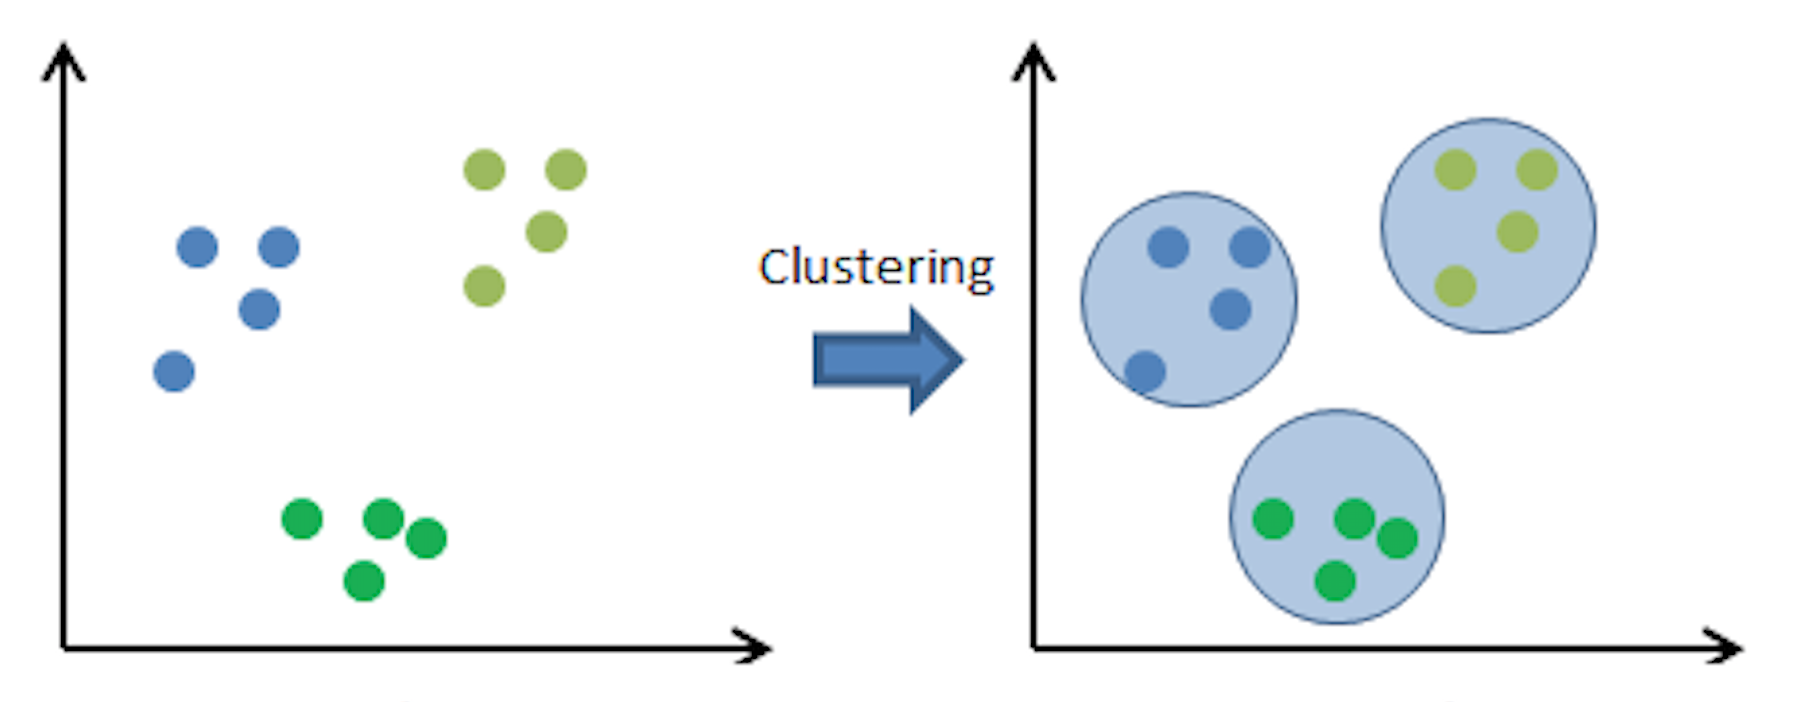

### Зачем?

- Классификация объектов. Попытка понять зависимости между объектами путем выявления их кластерной структуры.
- Сжатие данных. Можно сократить размер исходной выборки, взяв один или несколько наиболее типичных представителей каждого кластера.
- Выделение аномалий - объектов, которые не подходят по критериям ни в один кластер. Обнаруженные объекты в дальнейшем обрабатывают отдельно.

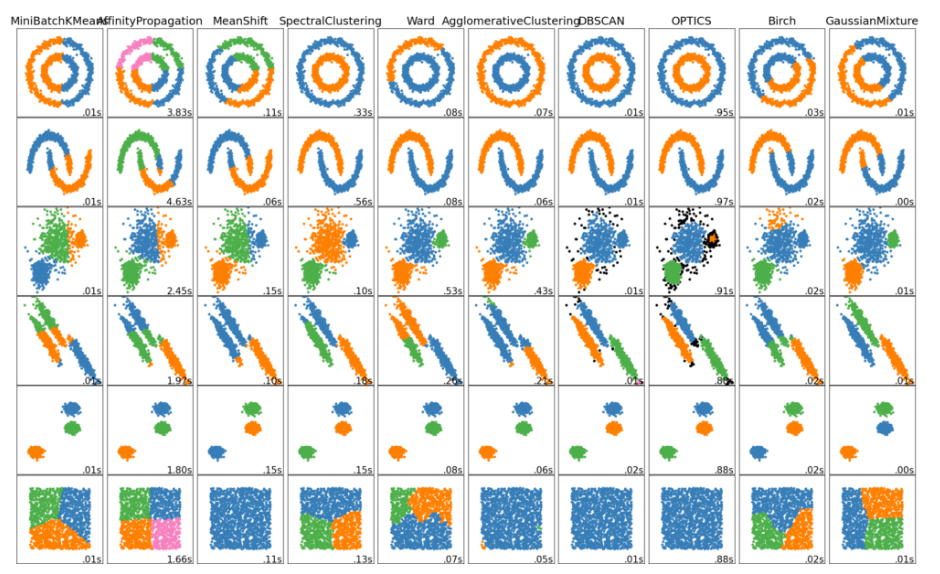

### K-means

#### Основная идея метода

Итеративное повторение двух шагов:

- Распределение объектов выборки по кластерам
- Пересчёт центров кластеров

Более подробно:

- Выбираются k центров будущих кластеров
- Каждый объект относят к одному из выбранных центров, ориентируясь на расстояние
- Центры кластеров пересчитываются как среднее арифметическое векторов вошедших в этот кластер объектов и обновляются
- Объекты относят к новым центрам кластеров
- ...

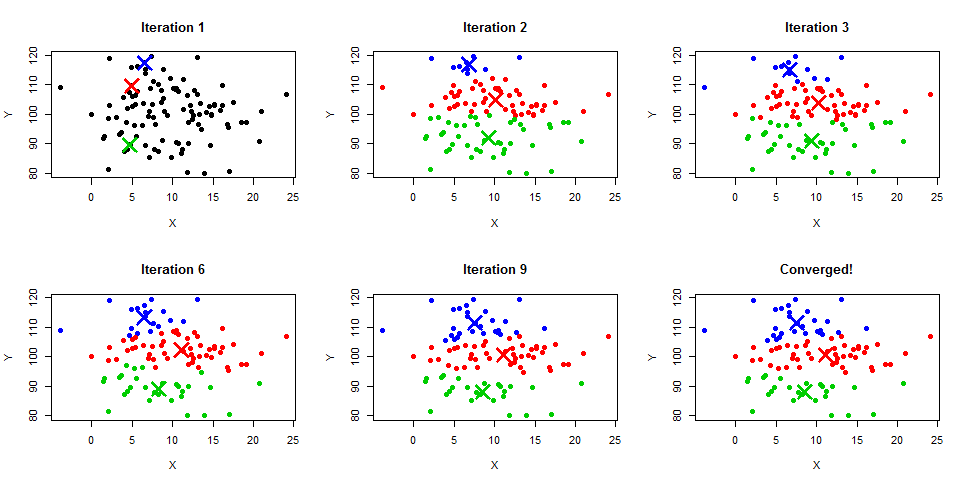

#### Проблемы

- Чувствительность к начальной инициализации
- Заранее необходимо знать k

#### Как подобрать количество кластеров?

Метод локтя

In [ ]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=2, shuffle=True, random_state=2023)

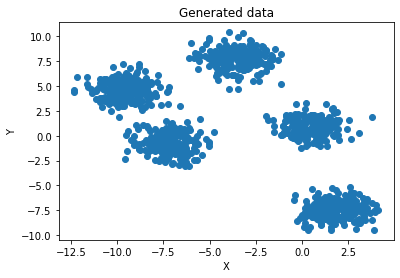

In [ ]:
plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

`inertia_` - сумма квадратов расстояний от объектов до ближайших центров кластеров

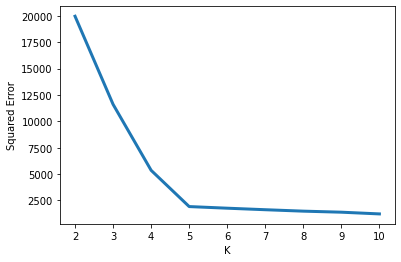

CPU times: user 796 ms, sys: 3.5 ms, total: 799 ms
Wall time: 489 ms


In [ ]:
%%time

se = []

for k in range(2, 11):
    clustering = KMeans(n_clusters=k, random_state=2024)
    clustering.fit(X)
    se.append(clustering.inertia_)

plt.plot(range(2, 11), se, linewidth='3')
plt.xlabel("K")
plt.ylabel("Squared Error")
plt.show()

Силуэт

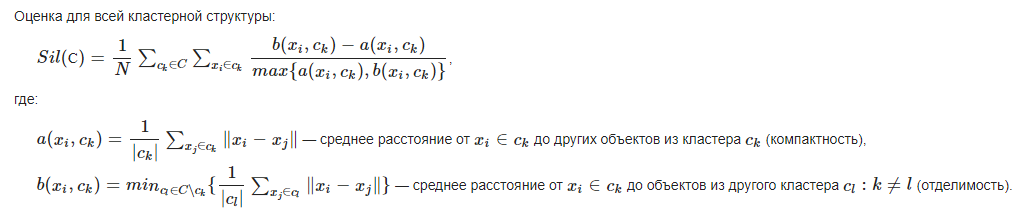

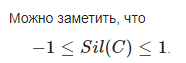

In [ ]:
silhouette = []

for k in range(2, 11):
  clustering = KMeans(n_clusters=k, random_state=2024).fit(X)
  labels = clustering.labels_
  silhouette.append(silhouette_score(X, labels, metric='euclidean'))

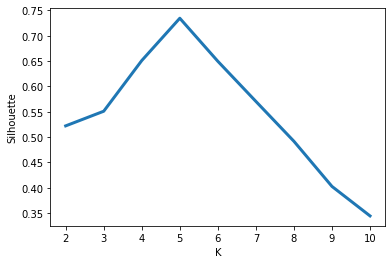

In [ ]:
plt.plot(range(2, 11), silhouette, linewidth='3')
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

### Метрики качества

#### Индекс Rand


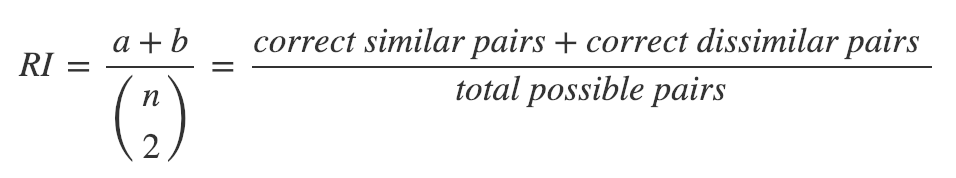

In [ ]:
rand_score([0, 0, 1, 2], [0, 0, 1, 1])

0.8333333333333334

[Оценка качества в задаче кластеризации](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)

### Иерархическая кластеризация

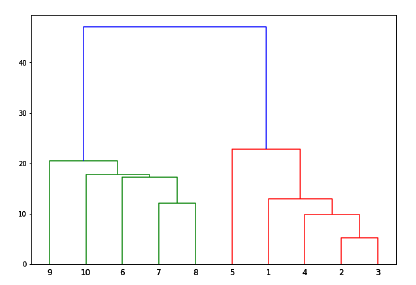

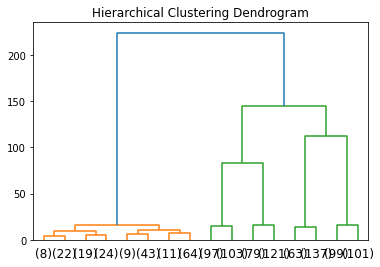

In [ ]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.show()

### DBSCAN

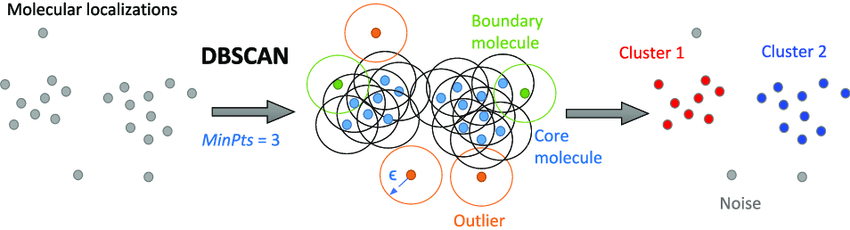

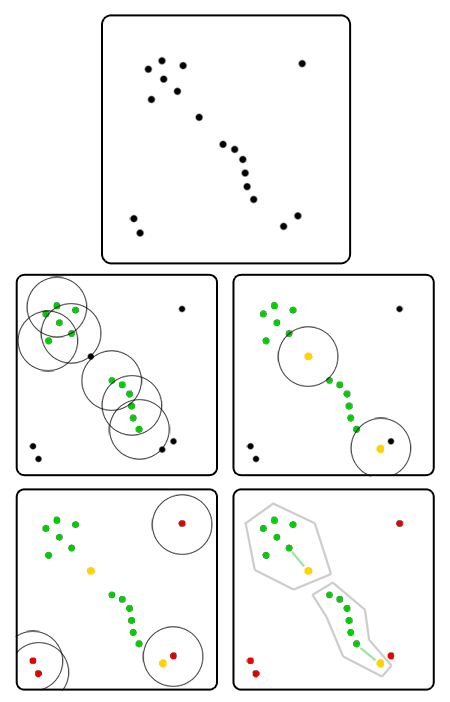

Алгоритм DBSCAN рассматривает кластеры, как участки высокой плотности, разделенные районами с низкой плотностью.

В алгоритме есть два параметра, `min_samples` и `eps`, которые формально определяют, что мы имеем в виду, когда говорим «плотный» . Высокие значения `min_samples` или низкие `eps` указывают на более высокую плотность, необходимую для формирования кластера.

Automatically created module for IPython interactive environment


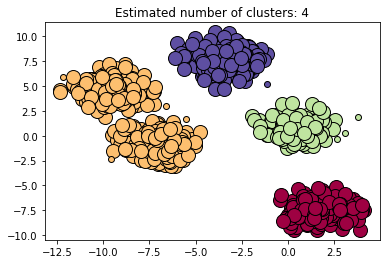

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaled = StandardScaler().fit_transform(X)


db = DBSCAN(eps=0.3, min_samples=10).fit(scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show();

## Поиск аномалий

### Isolation Forest

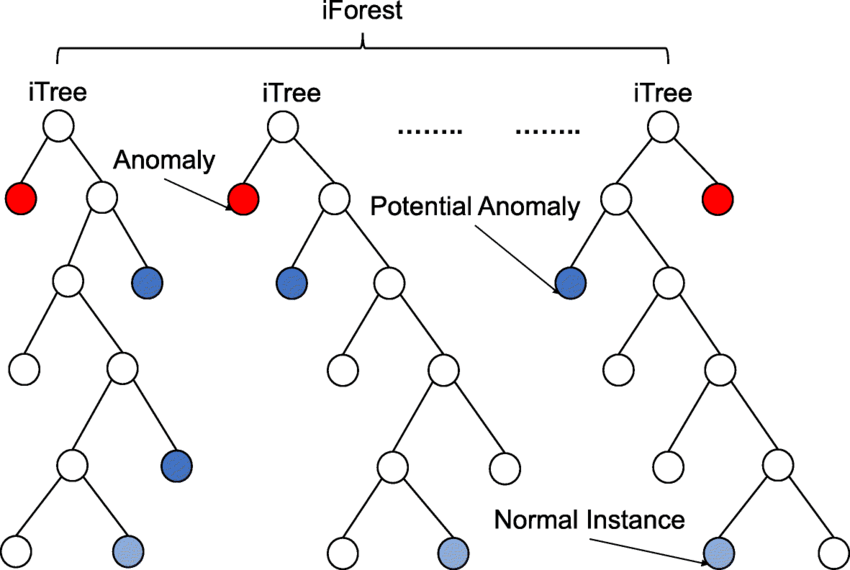

- Каждое дерево строится до исчерпании выборки
- Для построения ветвления в дереве: выбирается случайный признак и случайное расщепление
- Для каждого объекта мера его нормальности – среднее арифметическое глубин листьев, в которые он попал (изолировался)

In [ ]:
n_samples, n_outliers = 120, 40
rng = np.random.RandomState(2024)
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + np.array([2, 2])  # general
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])  # spherical
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))

X = np.concatenate([cluster_1, cluster_2, outliers])
y = np.concatenate(
    [np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

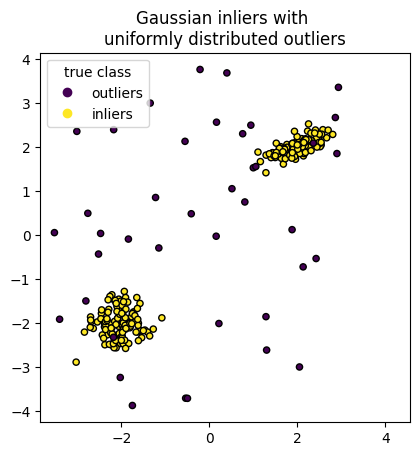

In [ ]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
handles, labels = scatter.legend_elements()
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.title("Gaussian inliers with \nuniformly distributed outliers")
plt.show()

In [ ]:
clf = IsolationForest(max_samples=100, random_state=2024)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=2024)

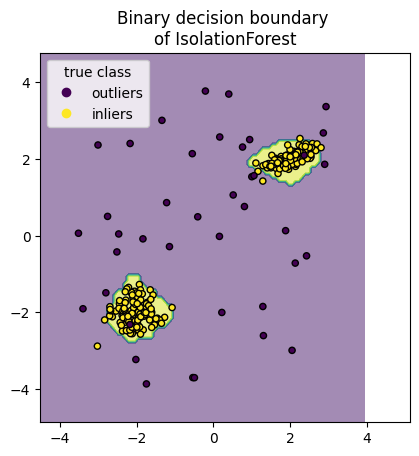

In [ ]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
disp.ax_.set_title("Binary decision boundary \nof IsolationForest")
plt.axis("square")
plt.legend(handles=handles, labels=["outliers", "inliers"], title="true class")
plt.show()

### One-class SVM

#### Немного об SVM

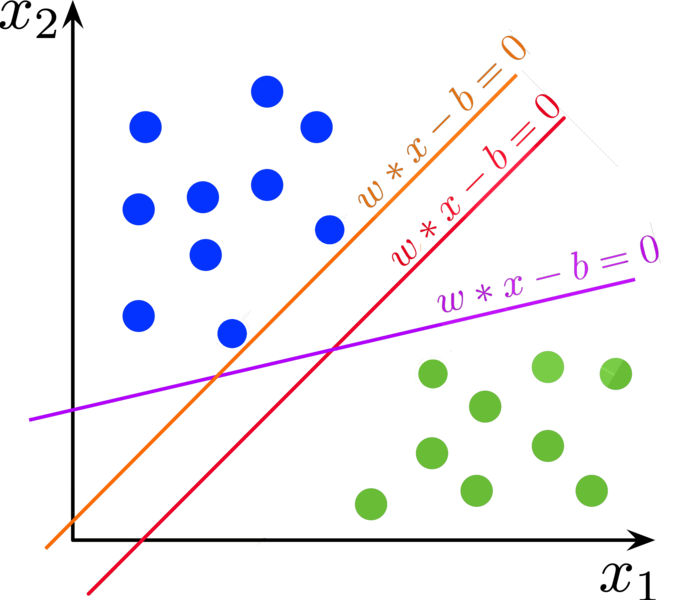

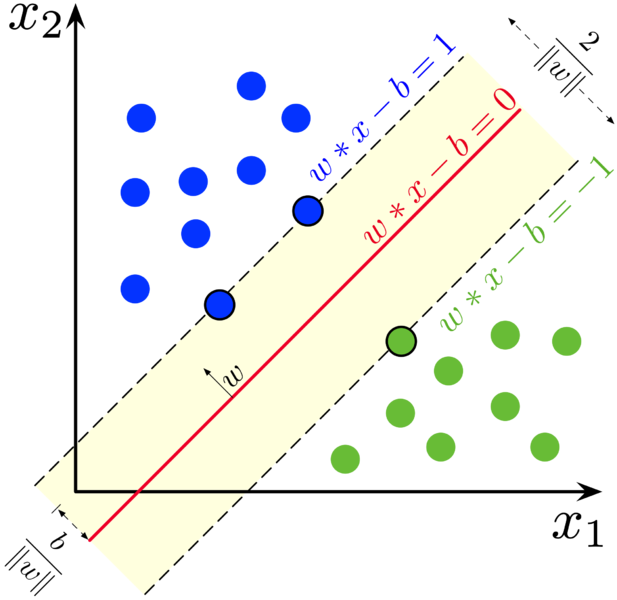

#### Почему метод **опорных векторов**?


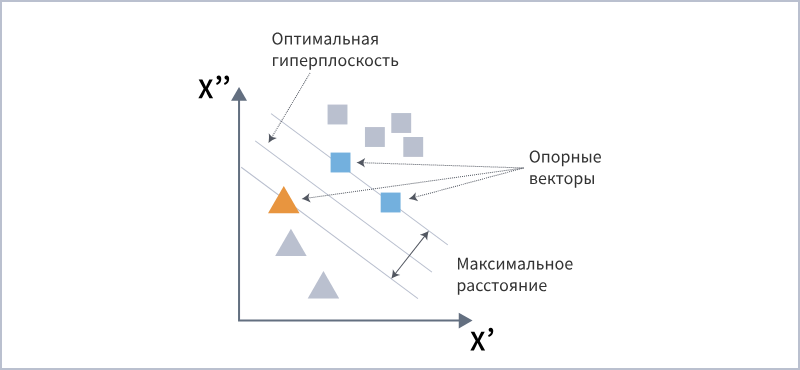

#### Детекция аномалий и **новизны**

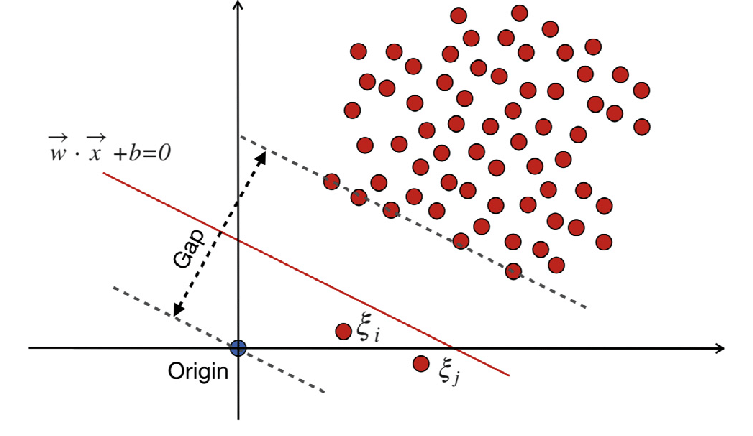

In [ ]:
X = 0.3 * rng.randn(500, 2)
X_train = np.r_[X + 2, X - 2]
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

nu = 0.05
gamma = 2.0


clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

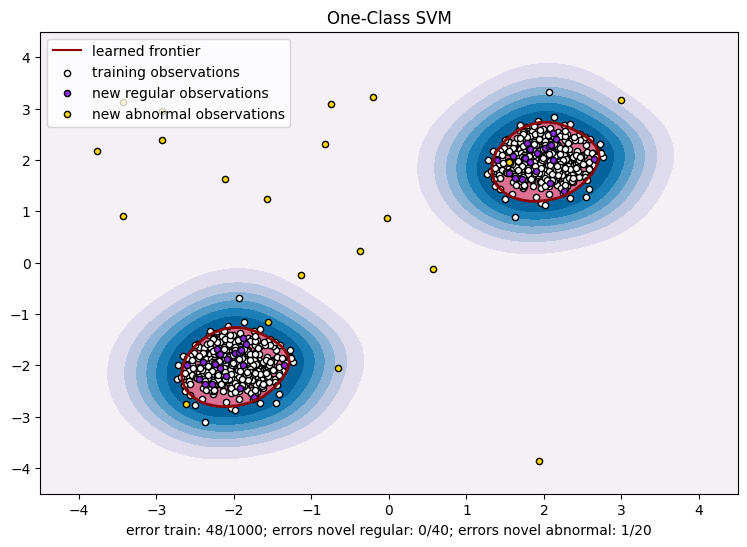

In [ ]:
_, ax = plt.subplots(figsize=(9, 6))

xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))
X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contour",
    ax=ax,
    linewidths=2,
    colors="darkred",
    levels=[0],
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    colors="palevioletred",
    levels=[0, clf.decision_function(X).max()],
)

s = 20
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")

ax.set(
    title="One-Class SVM",
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
    xlabel=(
        f"error train: {n_error_train}/{X_train.shape[0]}; "
        f"errors novel regular: {n_error_test}/{X_test.shape[0]}; "
        f"errors novel abnormal: {n_error_outliers}/{X_outliers.shape[0]}"
    ),
)
_ = ax.legend(
    [mlines.Line2D([], [], color="darkred", label="learned frontier"), b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
)